# [Numerical Analysis](https://www.math.sissa.it/course/phd-course-master-course/numerical-analysis-2021-2022) *end-of-course* project (a.y. 2021/2022)
by [Emanuele Ballarin](https://ballarin.cc) ([`emanuele@ballarin.cc`](mailto:emanuele@ballarin.cc))

Eventually-updated code available [on GitHub](https://github.com/emaballarin/numerical-analysis-2021-2022/tree/main/final_project) or [mirrored on SourceHut](https://git.sr.ht/~emaballarin/numerical-analysis-2021-2022/tree/main/item/final_project).

In [1]:
# Jupyter/IPython magics
%matplotlib inline

In [2]:
# Module imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Typing support
from typing import Callable, Tuple
from numpy.typing import NDArray

In [4]:
# Esceptions & testing support

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [5]:
from functions import finite_difference

Call the function using:

In [6]:
omega = [0, np.pi]
f = lambda x: np.sin(x)
n = 100
bc = [0, 0]

In [7]:
a, b = finite_difference(omega, f, n, bc)

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [8]:
from functions import lu_decomp, chol_decomp

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [9]:
from functions import l_solve, u_solve, lu_solve

Solve the derived linear system using the implemented functions and plot the computed solution:

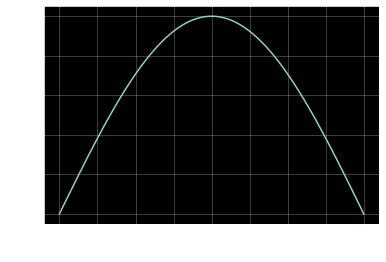

In [10]:
xs = np.linspace(0, np.pi, n)
_ = plt.plot(xs, lu_solve(a, b))
_ = plt.xticks(np.arange(0.0, (9/8)*np.pi, step=(np.pi/8)), ['0','π/8','π/4','3π/8','π/2','5π/8','3π/4', '7π/8', 'π'])
_ = plt.xlabel("x")
_ = plt.ylabel("u(x)")
_ = plt.grid(alpha=0.3, which="both")

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

In [11]:
omega_new = [0, 1]
f_new = lambda x: x * (1 - x)
u_analytical = np.vectorize(lambda x: x**4 / 12 - x**3/ 6 + x/ 12)
bc_new = [0, 0]

In [12]:
min_n = 3
max_n = int(1e3)
step_n = 10
err_linf = []

for n_new in range(min_n, max_n, step_n):
    a_new, b_new = finite_difference(omega_new, f_new, n_new, bc_new)
    lu_sol = lu_solve(a_new, b_new)
    xs_exact = np.linspace(omega_new[0], omega_new[1], n_new)
    ys_exact = u_analytical(xs_exact)
    err_linf.append(np.linalg.norm(ys_exact - lu_sol, np.inf))

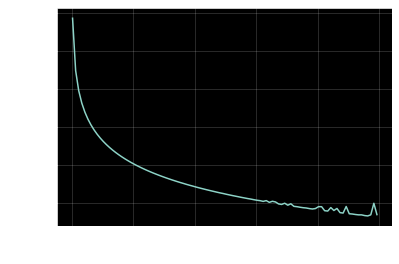

In [13]:
errtable = pd.DataFrame.from_dict({"numpts": (min_n + step_n*np.asarray(range(len(err_linf)))), "abserror": err_linf})
# print(errtable)
_ = plt.plot(errtable.numpts, errtable.abserror)
_ = plt.yscale("log")
_ = plt.xlabel("discretization points")
_ = plt.ylabel("Max error w.r.t. analytical sol.")
_ = plt.grid(alpha=0.2, which="both")

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [14]:
from functions import condition_number
condition_number(a)

5295.087852121188

Implement a preconditioned Conjugate Gradient method to solve the original linear system of equations using an iterative method:

In [17]:
def conjugate_gradient(a, b, P, nmax=len(a), eps=1e-10):
    pass  # TODO

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [ ]:
# TODO

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [ ]:
# TODO

Compute the inverse of the matrix A exploiting the derived LU factorization

In [ ]:
# TODO

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [ ]:
# TODO